### Import

In [17]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeOsaka
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from nftopt import nakanishi_fujii_todo

### Hamiltonian

In [4]:
hamiltonian = SparsePauliOp.from_list(
                [("IIII", -0.0996), 
                ("IIIZ", 0.1711), 
                ("IIZI", 0.1711), 
                ("IZII", -0.2225), 
                ("ZIII", -0.2225), 
                ("IIZZ", 0.1686), 
                ("IZIZ", 0.1205), 
                ("ZIIZ", 0.1658), 
                ("IZZI", 0.1658), 
                ("ZIZI", 0.1205), 
                ("ZZII", 0.1743), 
                ("XYYX", 0.0453), 
                ("YXXY", 0.0453), 
                ("YYXX", -0.0453), 
                ("XXYY", -0.0453)]
            )
# print(hamiltonian.to_matrix())

### Ansatz

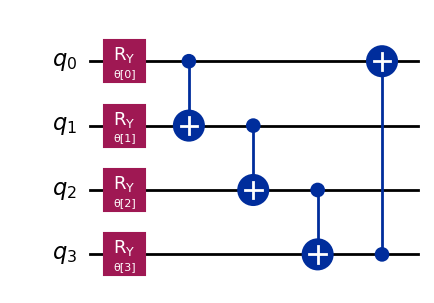

In [5]:
num_qubits = 4

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

ansatz.decompose().draw('mpl')

### Transpile

In [6]:
num_params = ansatz.num_parameters
num_params

4

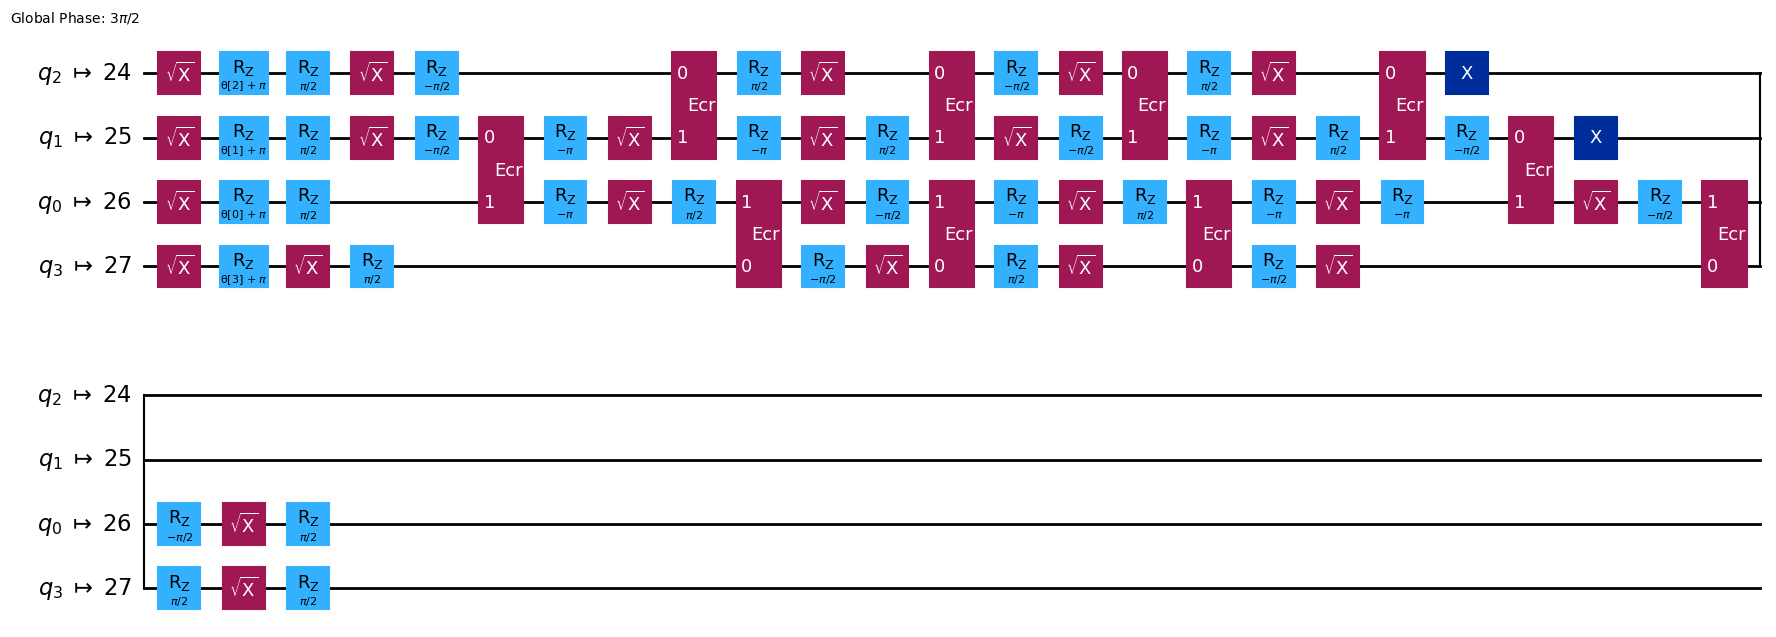

In [10]:
backend_answer = FakeOsaka()
optimization_level_answer = 2
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz)
isa_circuit.draw('mpl', idle_wires=False,)

In [12]:
# Define our Hamiltonian
hamiltonian_isa = hamiltonian.apply_layout(layout=isa_circuit.layout)

### Cost Function

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)

    print(energy)
    return energy, result

In [15]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
x0

array([6.01053846, 5.2824754 , 5.77197572, 2.47090891])

### Run using FakeOsaka Backend

In [18]:
backend = FakeOsaka()
# backend = AerSimulator()

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method=nakanishi_fujii_todo,
        options={'maxiter': 30})

/home/azhar04/anaconda3/envs/qiskit-1-2/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


-0.08636318359375002
-0.14102016601562498
-0.17419531249999998
-0.291365478515625
0.06404042968749998
-0.3824439453125
-0.51464912109375
-0.621681640625
-0.9386435546874999
-0.39564423828125
-0.33855878906250003
-0.182201171875
-0.44903066406250003
-0.34973081054687494
-0.37989506835937514
-0.7865154296875001
-0.7925926269531252
-0.34839873046875003
-0.3478748535156249
-0.3105677734375
-0.32848110351562504
-0.40617651367187496
-0.35039238281249996
-0.7848951660156251
-0.78401728515625
-0.388587255859375
-0.38325932617187497
-0.31993261718749993
-0.312500830078125
-0.36612734375000006
-0.37241875
-0.7821849609375
-0.7926326171875001
-0.36349184570312504
-0.355333984375
-0.33166201171875
-0.30092851562499995
-0.37331489257812495
-0.3617609863281249
-0.7921487792968751
-0.7875664550781251
-0.33338725585937495
-0.36838427734375007
-0.31572680664062514
-0.33031284179687503
-0.3742831054687498
-0.3707257812500001
-0.7958306152343751
-0.7860378417968751
-0.39479506835937483
-0.360951953125
-0